In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Embedding, Input,Conv2D,Softmax,Dropout,Dense,GRU,MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional
from tensorflow.keras.optimizers import Adam

In [2]:
Batch_size=32
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

In [3]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

--2023-05-29 07:20:43--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  66.4MB/s    in 36s     

2023-05-29 07:21:19 (72.1 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [4]:
!mkdir "/content/dataset/"

In [5]:
!tar -xjvf "/content/LJSpeech-1.1.tar.bz2" -C "/content/dataset/"

Streaming output truncated to the last 5000 lines.
LJSpeech-1.1/wavs/LJ022-0089.wav
LJSpeech-1.1/wavs/LJ030-0192.wav
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/LJ030-0

In [6]:
#Data Visualization

In [7]:
audio_binary=tf.io.read_file('/content/dataset/LJSpeech-1.1/wavs/LJ001-0001.wav')
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(212893,)


(212893,)


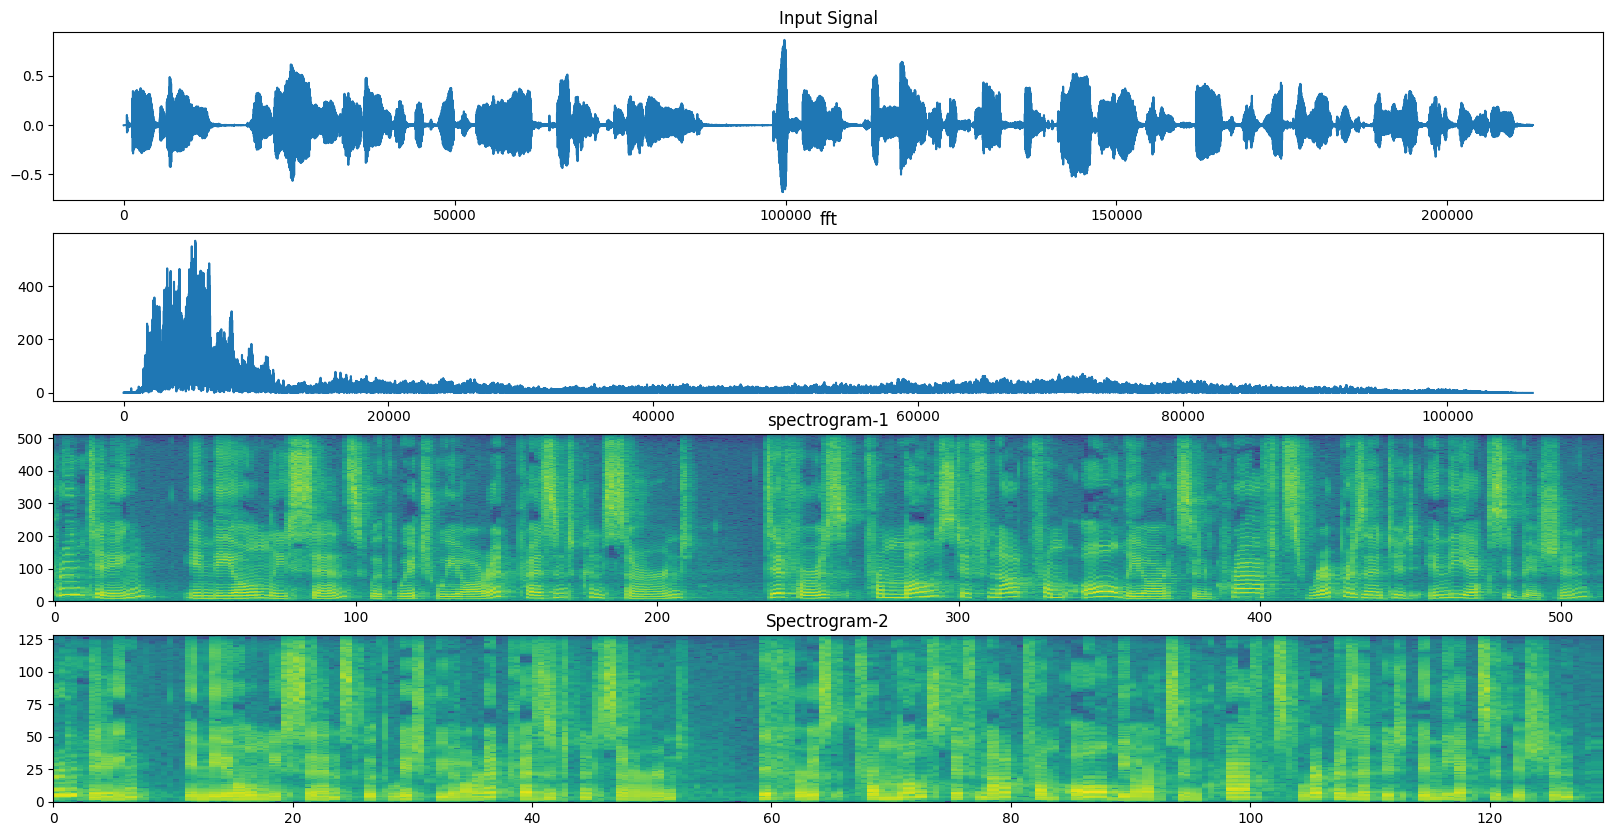

In [8]:
fig,axis=plt.subplots(4,figsize=(20,10))
L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")
fft=tf.signal.rfft(signal)
axis[1].plot(tf.abs(fft))
axis[1].set_title('fft')
spect=tf.signal.stft(signal,frame_length=1024,frame_step=512)
spect=tf.transpose(tf.abs(spect),[1,0])

power_spec=np.log(spect)
height=power_spec.shape[0]
width=power_spec.shape[1]
x=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
y=range(height)
axis[2].pcolormesh(x,y,power_spec)
axis[2].set_title("spectrogram-1")

spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


In [9]:
audio_text={}

In [10]:
csv_path="/content/dataset/LJSpeech-1.1/metadata.csv"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split("|")[0]
    text=line.strip().split("|")[1]
    audio_text[str(i)]=text

In [11]:
filepaths=["/content/dataset/LJSpeech-1.1/wavs/"+filename+".wav" for filename in list(audio_text.keys())]
transcriptions=[audio_text[str(filename)].lower() for filename in list(audio_text.keys())]
print(len(filepaths))
print(len(transcriptions))

13100
13100


In [12]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

In [13]:
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/LJSpeech-1.1/wavs/LJ001-0001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'>)


In [20]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [26]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [33]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [36]:
def get_spec(filepath,transcriptions):
  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)
  spectogram=tf.signal.stft(waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectogram=tf.abs(spectogram)
  label=get_label(transcriptions)
  return tf.expand_dims(spectogram,axis=-1),label

In [38]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(Batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [39]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [40]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(
[[[[7.12798326e-04]
   [4.62571252e-03]
   [6.20642118e-03]
   ...
   [1.35252572e-04]
   [7.60570110e-05]
   [3.36043013e-05]]

  [[4.23590001e-03]
   [7.16409134e-03]
   [3.25928186e-03]
   ...
   [9.35634525e-05]
   [5.88791190e-05]
   [2.21005175e-05]]

  [[3.52023495e-03]
   [1.79913249e-02]
   [2.51728334e-02]
   ...
   [3.46485089e-04]
   [1.54136491e-04]
   [1.43282465e-04]]

  ...

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]]


 [[[5.27175982e-03]
   [8.09575431e-03]
   [1.60869583e-02]
   ...
   [1.84492674e-04]
   [1.14722949e-04]
   [1.01984711e-04]]

  [[5.57353161e-03]
   [1.64909046e-02]
   [1.31872818e-01]
   ...
   [1.4465

In [42]:
normalization=tf.keras.layers.Normalization()

In [43]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")
model.summary()

Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizatio  (None, None, 129, 1)     3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (LayerN  (None, None, 65, 32)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Laye  (None, None, 33

In [44]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]
  
  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)
  
  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [45]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [46]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS
)

Epoch 1/100
  3/389 [..............................] - ETA: 13:21:37 - loss: 1787.6230

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model weights to a file on Google Drive
model.save_weights('/content/drive/MyDrive/my_model_Speech2Text_weights.h5')


In [ ]:
def get_spec_inference(filepath):
  
  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)
  
  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
      
  spectrogram=tf.abs(spectrogram)
  
  return tf.expand_dims(spectrogram,axis=-1)

In [ ]:
test_path="/content/LJ001-0005.wav"

In [ ]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)

In [ ]:
out

In [ ]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)

In [ ]:
print(out_str)

In [ ]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)
  
  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]
  
  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [ ]:
print(decode(tf.expand_dims(out,axis=0)))